X shape: (17258, 24, 21)
y shape: (17258, 12)


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 64)             │        22,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,492 (95.67 KB)

 Trainable params: 24,492 (95.67 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


346/346 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0013 - val_loss: 1.1029e-04
Epoch 2/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.1768e-05 - val_loss: 4.0096e-05
Epoch 3/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 6.7064e-06 - val_loss: 2.4687e-05
Epoch 4/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 6.6720e-06 - val_loss: 1.6566e-05
Epoch 5/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 5.4353e-06 - val_loss: 1.4751e-05
Epoch 6/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 5.3440e-06 - val_loss: 1.5852e-05
Epoch 7/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.1582e-06 - val_loss: 1.6364e-05
Epoch 8/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.9638e-06 - val_loss: 1.5446e-05
Epoch 9/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 4.9851e-06 - val_loss: 1.4606e-05
Epoch 10/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.9215e-06 - val_loss: 1.3508e-05
Epoch 11/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.0491e-06 - 

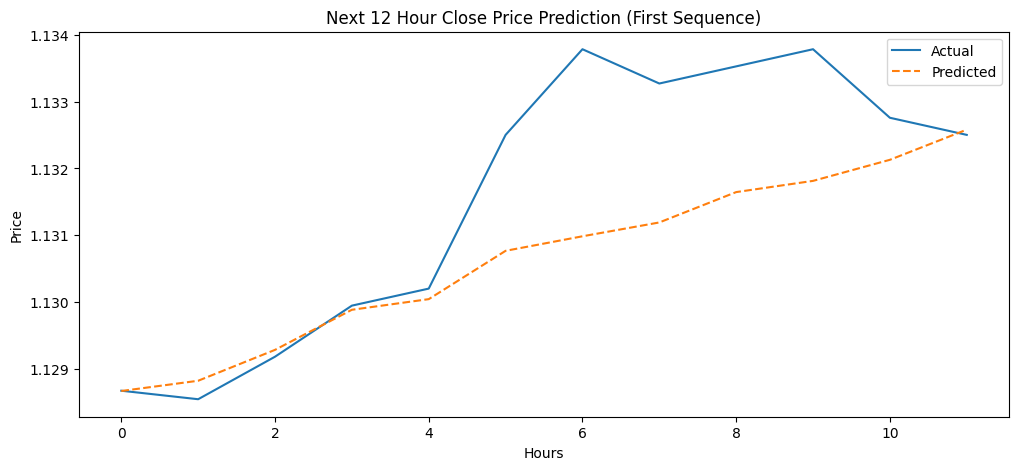

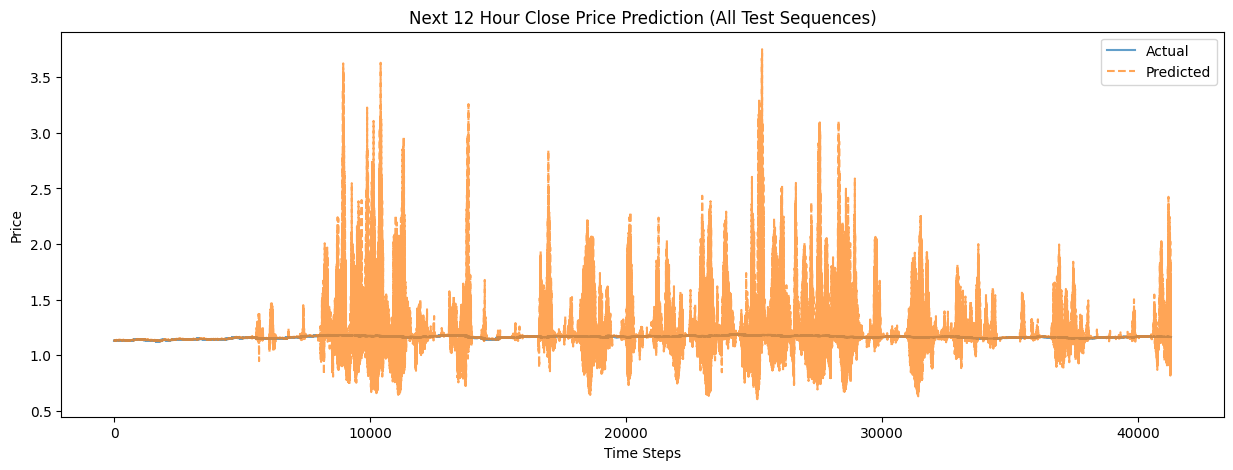

In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# -------------------------
# 1. LOAD DATA
# -------------------------
df = pd.read_csv("EURUSD=X_feature_data.csv", parse_dates=["Datetime"], index_col="Datetime")
# optional: if you want to drop IRD column that has NaNs
df = df.drop("interest_rate_differential", axis=1, errors="ignore")

# -------------------------
# 2. COMPUTE LOG RETURNS
# -------------------------
FORECAST = 12  # predict next 12 returns

# SAVE raw Close before any scaling/modification
df["Close_raw"] = df["Close"].copy()

# Create multi-step log-return targets (aligned so row t contains returns for t->t+1..t+FORECAST)
for i in range(1, FORECAST + 1):
    df[f"return_{i}h"] = np.log(df["Close"].shift(-i) / df["Close"])

# Drop rows with NaNs (these will be the last FORECAST rows)
df.dropna(inplace=True)

# -------------------------
# 3. FEATURES AND TARGETS
# -------------------------
target_cols = [f"return_{i}h" for i in range(1, FORECAST + 1)]

# Build feature list: everything except the target return columns and the raw price columns
# (we explicitly exclude "Close" and "Close_raw" from scaling / model features)
feature_cols = [c for c in df.columns if c not in target_cols and c not in ["Close", "Close_raw"]]

# Scale features only (do NOT scale returns or Close_raw)
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# -------------------------
# 4. CREATE SEQUENCES
# -------------------------
LOOKBACK = 24  # past 24 hours

def create_sequences(features, targets, lookback):
    X, y = [], []
    for i in range(len(features) - lookback):
        X.append(features[i:i+lookback])
        y.append(targets[i+lookback])
    return np.array(X), np.array(y)

X, y = create_sequences(df[feature_cols].values, df[target_cols].values, LOOKBACK)
print("X shape:", X.shape)  # (samples, LOOKBACK, features)
print("y shape:", y.shape)  # (samples, FORECAST)

# -------------------------
# 5. TRAIN/TEST SPLIT
# -------------------------
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# -------------------------
# 6. BUILD LSTM MODEL
# -------------------------
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(LOOKBACK, X.shape[2])),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(FORECAST)
])
model.compile(optimizer="adam", loss="mse")
model.summary()

# -------------------------
# 7. TRAIN MODEL
# -------------------------
es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

# -------------------------
# 8. PREDICT LOG RETURNS
# -------------------------
y_pred_log_returns = model.predict(X_test)
test_loss = model.evaluate(X_test, y_test)
print("Test MSE:", test_loss)

# -------------------------
# 9. RECONSTRUCT PREDICTED PRICES (USING RAW CLOSE)
# -------------------------
# We must only keep sequences for which a full FORECAST-length actual slice exists.
# Number of usable sequences from X_test:
num_sequences = len(y_pred_log_returns) - FORECAST + 1
if num_sequences <= 0:
    raise ValueError("Not enough test sequences to produce full FORECAST-length actual slices. "
                     "Reduce LOOKBACK or FORECAST or use more data.")

# Starting price for each forecast: last known actual close *before* the forecast begins
last_close = df["Close_raw"].values[split + LOOKBACK - 1 : split + LOOKBACK - 1 + num_sequences]

pred_prices = []
for i in range(num_sequences):
    cum_returns = np.exp(np.cumsum(y_pred_log_returns[i]))  # cumulative factor for 1..FORECAST
    prices = last_close[i] * cum_returns
    pred_prices.append(prices)
pred_prices = np.array(pred_prices)  # shape = (num_sequences, FORECAST)

# -------------------------
# 10. ALIGN ACTUAL PRICES (USING RAW CLOSE)
# -------------------------
actual_prices = np.array([
    df["Close_raw"].values[split + LOOKBACK + i : split + LOOKBACK + i + FORECAST]
    for i in range(num_sequences)
])

# -------------------------
# 11. PRINT EXAMPLES
# -------------------------
print("Predicted prices (first sequence):", pred_prices[0])
print("Actual prices (first sequence):   ", actual_prices[0])

# Sanity: check positivity and shapes
print("min(last_close):", last_close.min(), "max(last_close):", last_close.max())
print("pred_prices.shape:", pred_prices.shape, "actual_prices.shape:", actual_prices.shape)

# -------------------------
# 12. PLOT FIRST SEQUENCE
# -------------------------
plt.figure(figsize=(12,5))
plt.plot(actual_prices[0], label="Actual")
plt.plot(pred_prices[0], label="Predicted", linestyle="--")
plt.title("Next 12 Hour Close Price Prediction (First Sequence)")
plt.xlabel("Hours")
plt.ylabel("Price")
plt.legend()
plt.show()

# -------------------------
# 13. PLOT ALL PREDICTED VS ACTUAL (CONTINUOUS)
# -------------------------
pred_prices_cont = pred_prices.flatten()
actual_prices_cont = actual_prices.flatten()

plt.figure(figsize=(15,5))
plt.plot(actual_prices_cont, label="Actual", alpha=0.7)
plt.plot(pred_prices_cont, label="Predicted", linestyle="--", alpha=0.7)
plt.title("Next 12 Hour Close Price Prediction (All Test Sequences)")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.show()


In [22]:
actual_prices[19]

array([1.13442993, 1.13507378, 1.13365829, 1.13224638, 1.13327289,
       1.1331445 , 1.13198996, 1.13352978, 1.13301611, 1.13404405,
       1.13417268, 1.13365829])

In [20]:
df

,Close,High,Low,Open,Volume,rsi_14,macd,macd_signal,macd_hist,bollinger_upper,...,return_3h,return_4h,return_5h,return_6h,return_7h,return_8h,return_9h,return_10h,return_11h,return_12h
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-02-23 00:00:00,-0.948944,-0.958397,-0.945738,-0.960561,0.0,-0.153408,-0.036786,-0.039211,0.000293,-0.967752,...,0.001275,0.001168,0.000956,0.001168,0.000425,-0.000531,-0.001909,-0.001273,-0.000743,0.000212
2023-02-23 01:00:00,-0.922475,-0.934867,-0.936923,-0.951749,0.0,-0.153408,0.034892,-0.023967,0.188867,-0.967752,...,0.000213,0.000000,0.000213,-0.000531,-0.001486,-0.002865,-0.002229,-0.001698,-0.000743,-0.001168
2023-02-23 02:00:00,-0.919531,-0.931921,-0.925163,-0.928225,0.0,-0.153408,0.098206,0.001693,0.317720,-0.967752,...,-0.000106,0.000106,-0.000637,-0.001593,-0.002971,-0.002335,-0.001805,-0.000850,-0.001274,-0.001380
2023-02-23 03:00:00,-0.913639,-0.926035,-0.907502,-0.919395,0.0,-0.153408,0.162227,0.035837,0.422662,-0.967752,...,-0.000106,-0.000850,-0.001805,-0.003183,-0.002548,-0.002017,-0.001062,-0.001487,-0.001593,-0.002654
2023-02-23 04:00:00,-0.916584,-0.926035,-0.913390,-0.922340,0.0,-0.153408,0.202145,0.071641,0.443205,-0.967752,...,-0.000744,-0.001699,-0.003077,-0.002441,-0.001911,-0.000956,-0.001381,-0.001487,-0.002547,-0.003924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-09 22:00:00,1.697271,1.695140,1.709969,1.711754,0.0,-0.899974,-0.468520,-0.382199,-0.358765,1.695566,...,-0.000116,-0.000233,0.000000,0.000116,0.000349,0.000814,0.001979,0.002329,0.000931,0.000698
2025-12-09 23:00:00,1.704326,1.688082,1.713499,1.697639,0.0,-1.142238,-0.454280,-0.402391,-0.249492,1.693078,...,-0.000465,-0.000233,-0.000116,0.000116,0.000582,0.001746,0.002096,0.000698,0.000465,0.000465
2025-12-10 00:00:00,1.697271,1.688082,1.709969,1.704693,0.0,-0.977510,-0.457468,-0.419223,-0.207922,1.690448,...,0.000000,0.000116,0.000349,0.000814,0.001979,0.002329,0.000931,0.000698,0.000698,0.001164
